# 航空客户价值分析1
根据以下六个特征
- 入会时间	
- 飞行次数	
- 平均每公里票价	
- 乘机总里程	
- 时间间隔差值
  - 衡量用户乘机频率的稳定性
- 平均折扣率


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import visuals as vs
from sklearn.cluster import KMeans
from IPython.display import display # 使得我们可以对DataFrame使用display()函数

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
# 高分辨率显示
# %config InlineBackend.figure_format='retina'

# 载入整个客户数据集
try:
    data = pd.read_csv("air_data.csv",encoding="utf-8")
#     data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 62988 samples with 44 features each.


In [78]:
# 显示数据集的一个描述

print(data.shape)
display(data.describe())
# print(data.head())

(62044, 48)


,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,EP_SUM_YR_1,EP_SUM_YR_2,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,...,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight,入会时间,平均每公里票价,时间间隔差值,用户分类
count,62044.000000,62044.000000,61632.000000,62044.000000,62044.000000,62044.0,62044.000000,62044.000000,62044.000000,62044.000000,...,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044,62044.000000,62044.000000,62044.000000
mean,31485.237928,4.103652,42.504300,11.971359,11057.772468,0.0,269.732093,5389.298164,5676.826688,17321.694749,...,6726.731416,0.489666,0.510334,0.519388,0.471873,2.754191,1488 days 16:35:10.192766,0.646334,99.297629,2.597431
std,18188.650537,0.376322,9.885877,14.110619,16424.944888,0.0,1657.846655,8123.849287,8736.092628,21052.728111,...,12671.910738,0.317091,0.317091,0.337879,0.337318,7.399359,847 days 21:08:31.456866,0.280053,85.812874,1.357267
min,1.000000,4.000000,6.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,368.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365 days 00:00:00,0.016482,0.000000,0.000000
25%,15715.750000,4.000000,35.000000,3.000000,2599.000000,0.0,0.000000,1024.000000,856.000000,4874.000000,...,763.000000,0.250000,0.285714,0.256762,0.179310,0.000000,735 days 00:00:00,0.487486,34.666667,1.000000
50%,31476.500000,4.000000,41.000000,7.000000,5816.000000,0.0,0.000000,2832.000000,2838.000000,10200.000000,...,2929.500000,0.500000,0.500000,0.511677,0.480269,0.000000,1278 days 00:00:00,0.620636,84.435417,3.000000
75%,47247.250000,4.000000,48.000000,15.000000,13002.250000,0.0,0.000000,6617.000000,6928.000000,21522.500000,...,7609.000000,0.714286,0.750000,0.804233,0.730684,1.000000,2182 days 00:00:00,0.755678,143.076923,4.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,0.0,74460.000000,239560.000000,234188.000000,580717.000000,...,728282.000000,1.000000,1.000000,0.999989,0.999993,140.000000,3437 days 00:00:00,5.202103,547.310345,4.000000


### 数据清理

In [3]:
data = data[data["SUM_YR_1"].notnull() & data["SUM_YR_2"].notnull()]
index1 = data["SUM_YR_1"] != 0
index2 = data["SUM_YR_2"] != 0
index3 = (data["SEG_KM_SUM"] == 0) & (data["avg_discount"] == 0)
data = data[index1 | index2| index3]
print(data.shape)

(62044, 44)


,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight,入会时间,平均每公里票价,时间间隔差值
0,54993,2006-11-02,2008/12/24,男,6,.,北京,CN,31.0,2014-03-31,...,619760,370211,0.509524,0.490476,0.487221,0.512777,50,2706 days,0.815798,14.516746
1,28065,2007-02-19,2007/08/03,男,6,NaN,北京,CN,42.0,2014-03-31,...,415768,238410,0.514286,0.485714,0.489289,0.510708,33,2597 days,1.154043,11.805755
2,55106,2007-02-01,2007/08/30,男,6,.,北京,CN,40.0,2014-03-31,...,406361,233798,0.518519,0.481481,0.481467,0.518530,26,2615 days,1.158217,12.701493
3,21189,2008-08-22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014-03-31,...,372204,186100,0.434783,0.565217,0.551722,0.448275,12,2047 days,0.859648,45.136364
4,39546,2009-04-10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014-03-31,...,338813,210365,0.532895,0.467105,0.469054,0.530943,39,1816 days,0.823617,42.211921


### 特征选取

In [4]:
# 入会时间，飞行次数，第一年总票价，第二年总票价，总里程数，平均折扣，平均乘机间隔，最大乘机间隔
filter_data = data[[ "FFP_DATE", "LOAD_TIME", "FLIGHT_COUNT", "SUM_YR_1", "SUM_YR_2", "SEG_KM_SUM", "AVG_INTERVAL" , "MAX_INTERVAL", "avg_discount"]]
filter_data[0:5]

,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,AVG_INTERVAL,MAX_INTERVAL,avg_discount
0,2006/11/02,2014/03/31,210,239560.0,234188.0,580717,3.483254,18,0.961639
1,2007/02/19,2014/03/31,140,171483.0,167434.0,293678,5.194245,17,1.252314
2,2007/02/01,2014/03/31,135,163618.0,164982.0,283712,5.298507,18,1.254676
3,2008/08/22,2014/03/31,23,116350.0,125500.0,281336,27.863636,73,1.090870
4,2009/04/10,2014/03/31,152,124560.0,130702.0,309928,4.788079,47,0.970658


In [28]:
# 特征筛选
data["LOAD_TIME"] = pd.to_datetime(data["LOAD_TIME"])
data["FFP_DATE"] = pd.to_datetime(data["FFP_DATE"])
data["入会时间"] = data["LOAD_TIME"] - data["FFP_DATE"]
data["平均每公里票价"] = (data["SUM_YR_1"] + data["SUM_YR_2"]) / data["SEG_KM_SUM"]
# 最大乘机时间间隔-平均时间间隔，可能是用户乘机需求稳定性的判别指标
data["时间间隔差值"] = data["MAX_INTERVAL"] - data["AVG_INTERVAL"]
deal_data = data.rename(
    columns = {"FLIGHT_COUNT" : "飞行次数", "SEG_KM_SUM" : "总里程", "avg_discount" : "平均折扣率"},
    inplace = False
)
filter_data = deal_data[["入会时间", "飞行次数", "平均每公里票价", "总里程", "时间间隔差值", "平均折扣率"]]
display(filter_data[0:5])
filter_data['入会时间'] = filter_data['入会时间'].astype(np.int64)/(60*60*24*10**9)
display(filter_data[0:5])
# print(filter_data.info())

,入会时间,飞行次数,平均每公里票价,总里程,时间间隔差值,平均折扣率
0,2706 days,210,0.815798,580717,14.516746,0.961639
1,2597 days,140,1.154043,293678,11.805755,1.252314
2,2615 days,135,1.158217,283712,12.701493,1.254676
3,2047 days,23,0.859648,281336,45.136364,1.090870
4,1816 days,152,0.823617,309928,42.211921,0.970658


D:\TEST\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,入会时间,飞行次数,平均每公里票价,总里程,时间间隔差值,平均折扣率
0,2706.0,210,0.815798,580717,14.516746,0.961639
1,2597.0,140,1.154043,293678,11.805755,1.252314
2,2615.0,135,1.158217,283712,12.701493,1.254676
3,2047.0,23,0.859648,281336,45.136364,1.090870
4,1816.0,152,0.823617,309928,42.211921,0.970658


In [29]:
# 标准化
filter_zscore_data = (filter_data - filter_data.mean(axis=0))/(filter_data.std(axis=0))
filter_zscore_data[0:5]

,入会时间,飞行次数,平均每公里票价,总里程,时间间隔差值,平均折扣率
0,1.435707,14.034016,0.605115,26.761154,-0.987974,1.295540
1,1.307152,9.073213,1.812903,13.126864,-1.019566,2.868176
2,1.328381,8.718869,1.827807,12.653481,-1.009128,2.880950
3,0.658476,0.781585,0.761692,12.540622,-0.631155,1.994714
4,0.386032,9.923636,0.633034,13.898736,-0.665235,1.344335


In [32]:
def distEclud(vecA, vecB):
    """
    计算两个向量的欧式距离的平方，并返回
    """
    return np.sum(np.power(vecA - vecB, 2))
 
def test_Kmeans_nclusters(data_train):
    """
    计算不同的k值时，SSE的大小变化
    """
    data_train = data_train.values
    nums=range(2,10)
    SSE = []
    for num in nums:
        sse = 0
        kmodel = KMeans(n_clusters=num, n_jobs=4)
        kmodel.fit(data_train)
        # 簇中心
        cluster_ceter_list = kmodel.cluster_centers_
        # 个样本属于的簇序号列表
        cluster_list = kmodel.labels_.tolist()
        for index in  range(len(data_train)):
            cluster_num = cluster_list[index]
            sse += distEclud(data_train[index, :], cluster_ceter_list[cluster_num])
#         print("簇数是",num , "时； SSE是", sse)
        SSE.append(sse)
    return nums, SSE
 
nums, SSE = test_Kmeans_nclusters(filter_zscore_data)

D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in 

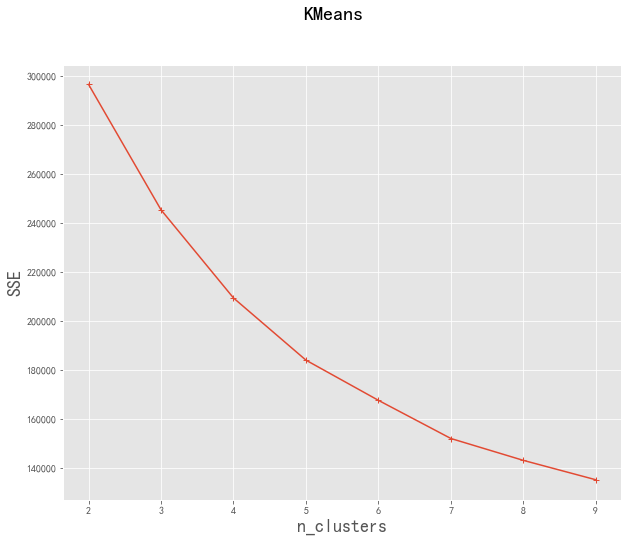

In [25]:
#画图，通过观察SSE与k的取值尝试找出合适的k值
# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.unicode_minus'] = False
# 使用ggplot的绘图风格
plt.style.use('ggplot')

## 绘图观测SSE与簇个数的关系
fig=plt.figure(figsize=(10, 8))
ax=fig.add_subplot(1,1,1)
ax.plot(nums,SSE,marker="+")
ax.set_xlabel("n_clusters", fontsize=18)
ax.set_ylabel("SSE", fontsize=18)
fig.suptitle("KMeans", fontsize=20)
plt.show()

## Kmeans聚类参数分析

#### N=5

D:\TEST\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


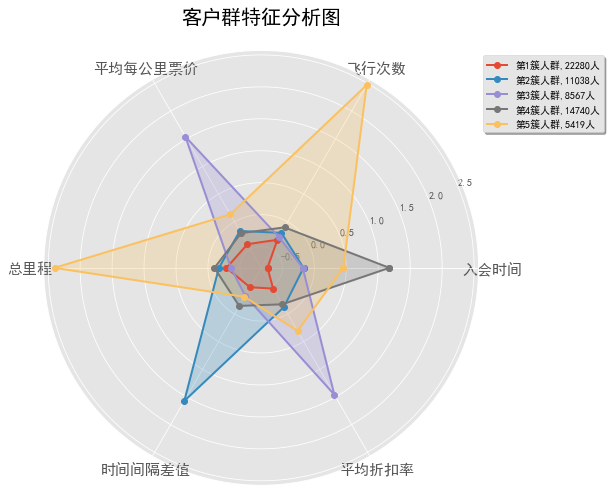

In [76]:
kmodel = KMeans(n_clusters=5, n_jobs=5)
kmodel.fit(filter_zscore_data)
# 简单打印结果
r1 = pd.Series(kmodel.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(kmodel.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(filter_zscore_data.columns) + [u'类别数目'] #重命名表头
 
# 绘图
fig=plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ["入会时间", "飞行次数", "平均每公里票价", "总里程", "时间间隔差值", "平均折扣率"]
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()

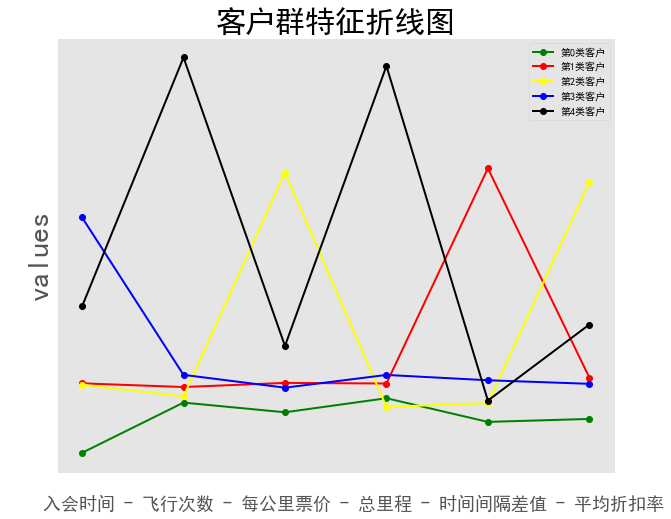

In [77]:
# 代表六个维度
x=[1,2,3,4,5,6] # 
colors=['green','red','yellow','blue','black']
fig=plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(x,kmodel.cluster_centers_[i],label=('第%d类客户'%(i)),linewidth=2,color=colors[i],marker='o')
    plt.legend()
plt.title('客户群特征折线图',fontsize=30)
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.xlabel('\n    入会时间 - 飞行次数 - 每公里票价 - 总里程 - 时间间隔差值 - 平均折扣率',fontsize=18)
plt.ylabel('values', fontsize=30)
plt.show()

In [24]:
preds = kmodel.predict(filter_zscore_data)
print(preds[62000:])

[4 4 4 4 2 4 4 4 4 4 3 2 2 2 2 4 2 4 4 4 2 3 2 2 4 4 2 2 2 2 2 2 4 4 4 3 4
 4 4 2 2 4 4 4]


In [27]:
r.head()

,入会时间,飞行次数,平均每公里票价,总里程,时间间隔差值,平均折扣率,类别数目
0,0.451123,2.458553,0.129806,2.388547,-0.308511,0.302638,5451
1,-0.174605,-0.196928,-0.165720,-0.169248,1.559393,-0.121936,11141
2,-0.182593,-0.276483,1.542384,-0.360820,-0.331826,1.462891,8534
3,1.175695,-0.104998,-0.203416,-0.105446,-0.145067,-0.172526,14726
4,-0.733233,-0.329328,-0.405394,-0.293406,-0.487477,-0.459981,22192


“第几”为随机

1.第一簇人群，10957人，最大的特点是时间间隔差值最大，分析可能是“季节型客户”，一年中在某个时间段需要多次乘坐飞机进行旅行，其他的时间则出行的不多，这类客户我们需要在保持的前提下，进行一定的发展；

2.第二簇人群，14732人，最大的特点就是入会的时间较长，属于老客户按理说平均折扣率应该较高才对，但是观察窗口的平均折扣率较低，而且总里程和总次数都不高，分析可能是流失的客户，需要在争取一下，尽量让他们“回心转意”；

3.第三簇人群，22188人，各方面的数据都是比较低的，属于一般或低价值用户

4.第三簇人群，8724人，最大的特点就是平均每公里票价和平均折扣率都是最高的，应该是属于乘坐高等舱的商务人员，应该重点保持的对象，也是需要重点发展的对象，另外应该积极采取相关的优惠政策是他们的乘坐次数增加

5.第五簇人群，5443人， 总里程和飞行次数都是最多的，而且平均每公里票价也较高，是重点保持对象

### 模型评估

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = filter_zscore_data
y = preds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

clf = RandomForestClassifier(random_state=123)
clf.fit(X_train,y_train)
score_filter = clf.score(X_test, y_test)

score_filter

0.9813844790071722

### 聚类输出并保存结果

In [35]:
new_data = data
new_data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight,入会时间,平均每公里票价,时间间隔差值
0,54993,2006-11-02,2008/12/24,男,6,.,北京,CN,31.0,2014-03-31,...,619760,370211,0.509524,0.490476,0.487221,0.512777,50,2706 days,0.815798,14.516746
1,28065,2007-02-19,2007/08/03,男,6,NaN,北京,CN,42.0,2014-03-31,...,415768,238410,0.514286,0.485714,0.489289,0.510708,33,2597 days,1.154043,11.805755
2,55106,2007-02-01,2007/08/30,男,6,.,北京,CN,40.0,2014-03-31,...,406361,233798,0.518519,0.481481,0.481467,0.518530,26,2615 days,1.158217,12.701493
3,21189,2008-08-22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014-03-31,...,372204,186100,0.434783,0.565217,0.551722,0.448275,12,2047 days,0.859648,45.136364
4,39546,2009-04-10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014-03-31,...,338813,210365,0.532895,0.467105,0.469054,0.530943,39,1816 days,0.823617,42.211921


In [36]:
new_data['用户分类'] = preds
new_data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight,入会时间,平均每公里票价,时间间隔差值,用户分类
0,54993,2006-11-02,2008/12/24,男,6,.,北京,CN,31.0,2014-03-31,...,370211,0.509524,0.490476,0.487221,0.512777,50,2706 days,0.815798,14.516746,0
1,28065,2007-02-19,2007/08/03,男,6,NaN,北京,CN,42.0,2014-03-31,...,238410,0.514286,0.485714,0.489289,0.510708,33,2597 days,1.154043,11.805755,0
2,55106,2007-02-01,2007/08/30,男,6,.,北京,CN,40.0,2014-03-31,...,233798,0.518519,0.481481,0.481467,0.518530,26,2615 days,1.158217,12.701493,0
3,21189,2008-08-22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014-03-31,...,186100,0.434783,0.565217,0.551722,0.448275,12,2047 days,0.859648,45.136364,0
4,39546,2009-04-10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014-03-31,...,210365,0.532895,0.467105,0.469054,0.530943,39,1816 days,0.823617,42.211921,0


In [39]:
new_data.to_csv('air_data_done1.csv',index=False,header=True,encoding="utf_8_sig")